In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [79]:
df = pd.read_csv('Dropbox.csv')
print(df.shape)
df = df.sample(200)
print(df.shape)

(10000, 3)
(200, 3)


In [80]:
df.head()

,reviewId,content,score
6804,6b3caa0c-a8e8-44a6-b38d-edc1ed9a36f9,"It used to be good, not anymore, it's now base...",1
5603,5d06af0e-df9b-4eaf-8f6d-e99427eeb8dc,Excellent awesome,5
3380,83dcaaf6-e0eb-4246-bcf7-dc08c32ebb05,My cloud storage companion since first use. Re...,5
2712,49ec35df-7024-4767-836f-36a2c42fc8c8,excellent,5
5436,42b9e26e-8216-4a3d-b31b-ded6f5225f51,Good 👍 👍,5


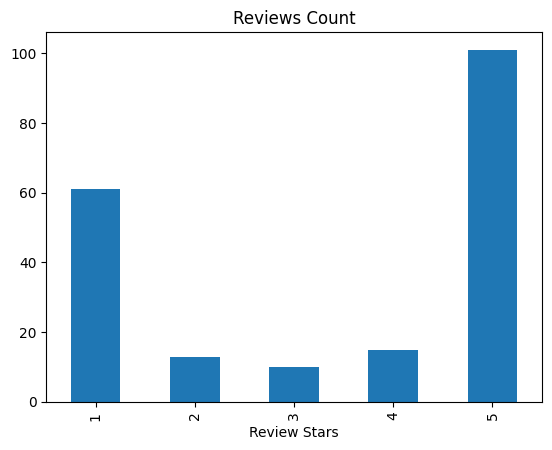

In [81]:
df['score'].value_counts().sort_index().plot(kind='bar', title='Reviews Count')
plt.xlabel("Review Stars")
plt.show()

In [49]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('So happy to be here')

{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.6115}

In [11]:
sia.polarity_scores('worst customer service ever')

{'neg': 0.577, 'neu': 0.423, 'pos': 0.0, 'compound': -0.6249}

In [82]:
df = df.drop(['reviewId'], axis=1).reset_index(drop=True)
df['Id'] = df.index
example = df['content'][0]
print("Content: ", example)
print("scores: ", sia.polarity_scores(example))

Content:  It used to be good, not anymore, it's now based on a plan in order to save anything from photos to files, and not cheap or affordable, the minimum offer I got was about $155 per year or $16 a month, sorry but I guess unless you make it affordable, I will probably not subscribe to such a thing, specially when I have a big family and the money goes for more important bills and groceries... disappointed!
scores:  {'neg': 0.069, 'neu': 0.839, 'pos': 0.092, 'compound': 0.1733}


In [83]:
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['content']
  id = row['Id']
  result[id] = sia.polarity_scores(text)

  0%|          | 0/200 [00:00<?, ?it/s]

In [84]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [85]:
vaders.head()

,Id,neg,neu,pos,compound,content,score
0,0,0.069,0.839,0.092,0.1733,"It used to be good, not anymore, it's now base...",1
1,1,0.000,0.000,1.000,0.8316,Excellent awesome,5
2,2,0.000,0.902,0.098,0.3612,My cloud storage companion since first use. Re...,5
3,3,0.000,0.000,1.000,0.5719,excellent,5
4,4,0.000,0.000,1.000,0.4404,Good 👍 👍,5


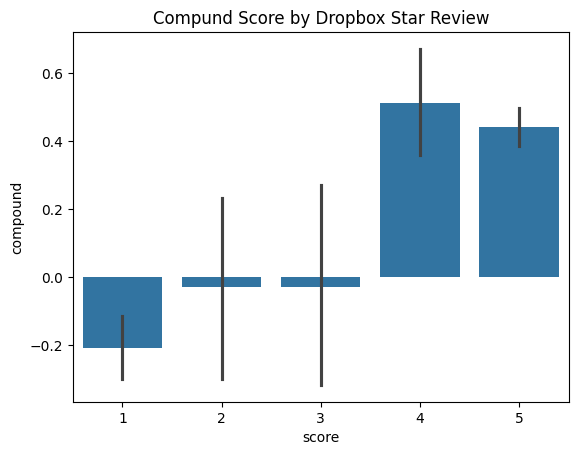

In [86]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compund Score by Dropbox Star Review')
plt.show()

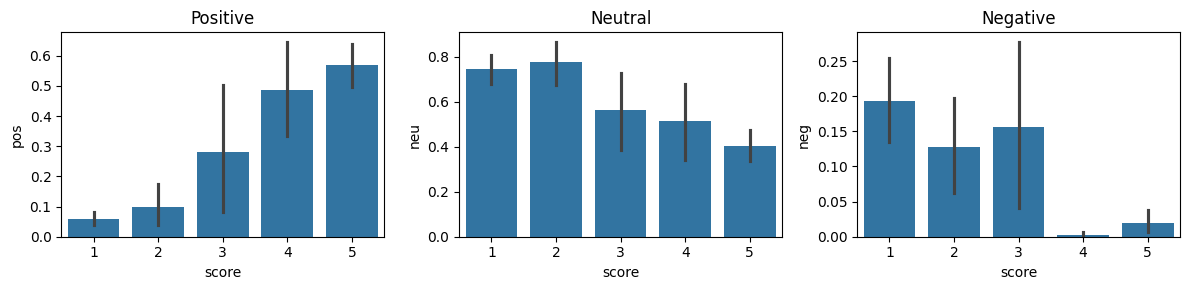

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [69]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [70]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [88]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(example)
print(sia.polarity_scores(example))
print(scores_dict)

It used to be good, not anymore, it's now based on a plan in order to save anything from photos to files, and not cheap or affordable, the minimum offer I got was about $155 per year or $16 a month, sorry but I guess unless you make it affordable, I will probably not subscribe to such a thing, specially when I have a big family and the money goes for more important bills and groceries... disappointed!
{'neg': 0.069, 'neu': 0.839, 'pos': 0.092, 'compound': 0.1733}
{'roberta_neg': np.float32(0.849034), 'roberta_neu': np.float32(0.12717444), 'roberta_pos': np.float32(0.023791568)}


In [89]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [91]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/200 [00:00<?, ?it/s]

In [92]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [93]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,content,score
0,0,0.069,0.839,0.092,0.1733,0.849034,0.127174,0.023792,"It used to be good, not anymore, it's now base...",1
1,1,0.000,0.000,1.000,0.8316,0.010842,0.089227,0.899931,Excellent awesome,5
2,2,0.000,0.902,0.098,0.3612,0.001349,0.021216,0.977435,My cloud storage companion since first use. Re...,5
3,3,0.000,0.000,1.000,0.5719,0.008278,0.083049,0.908672,excellent,5
4,4,0.000,0.000,1.000,0.4404,0.008477,0.129124,0.862399,Good 👍 👍,5


In [94]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'content', 'score'],
      dtype='object')

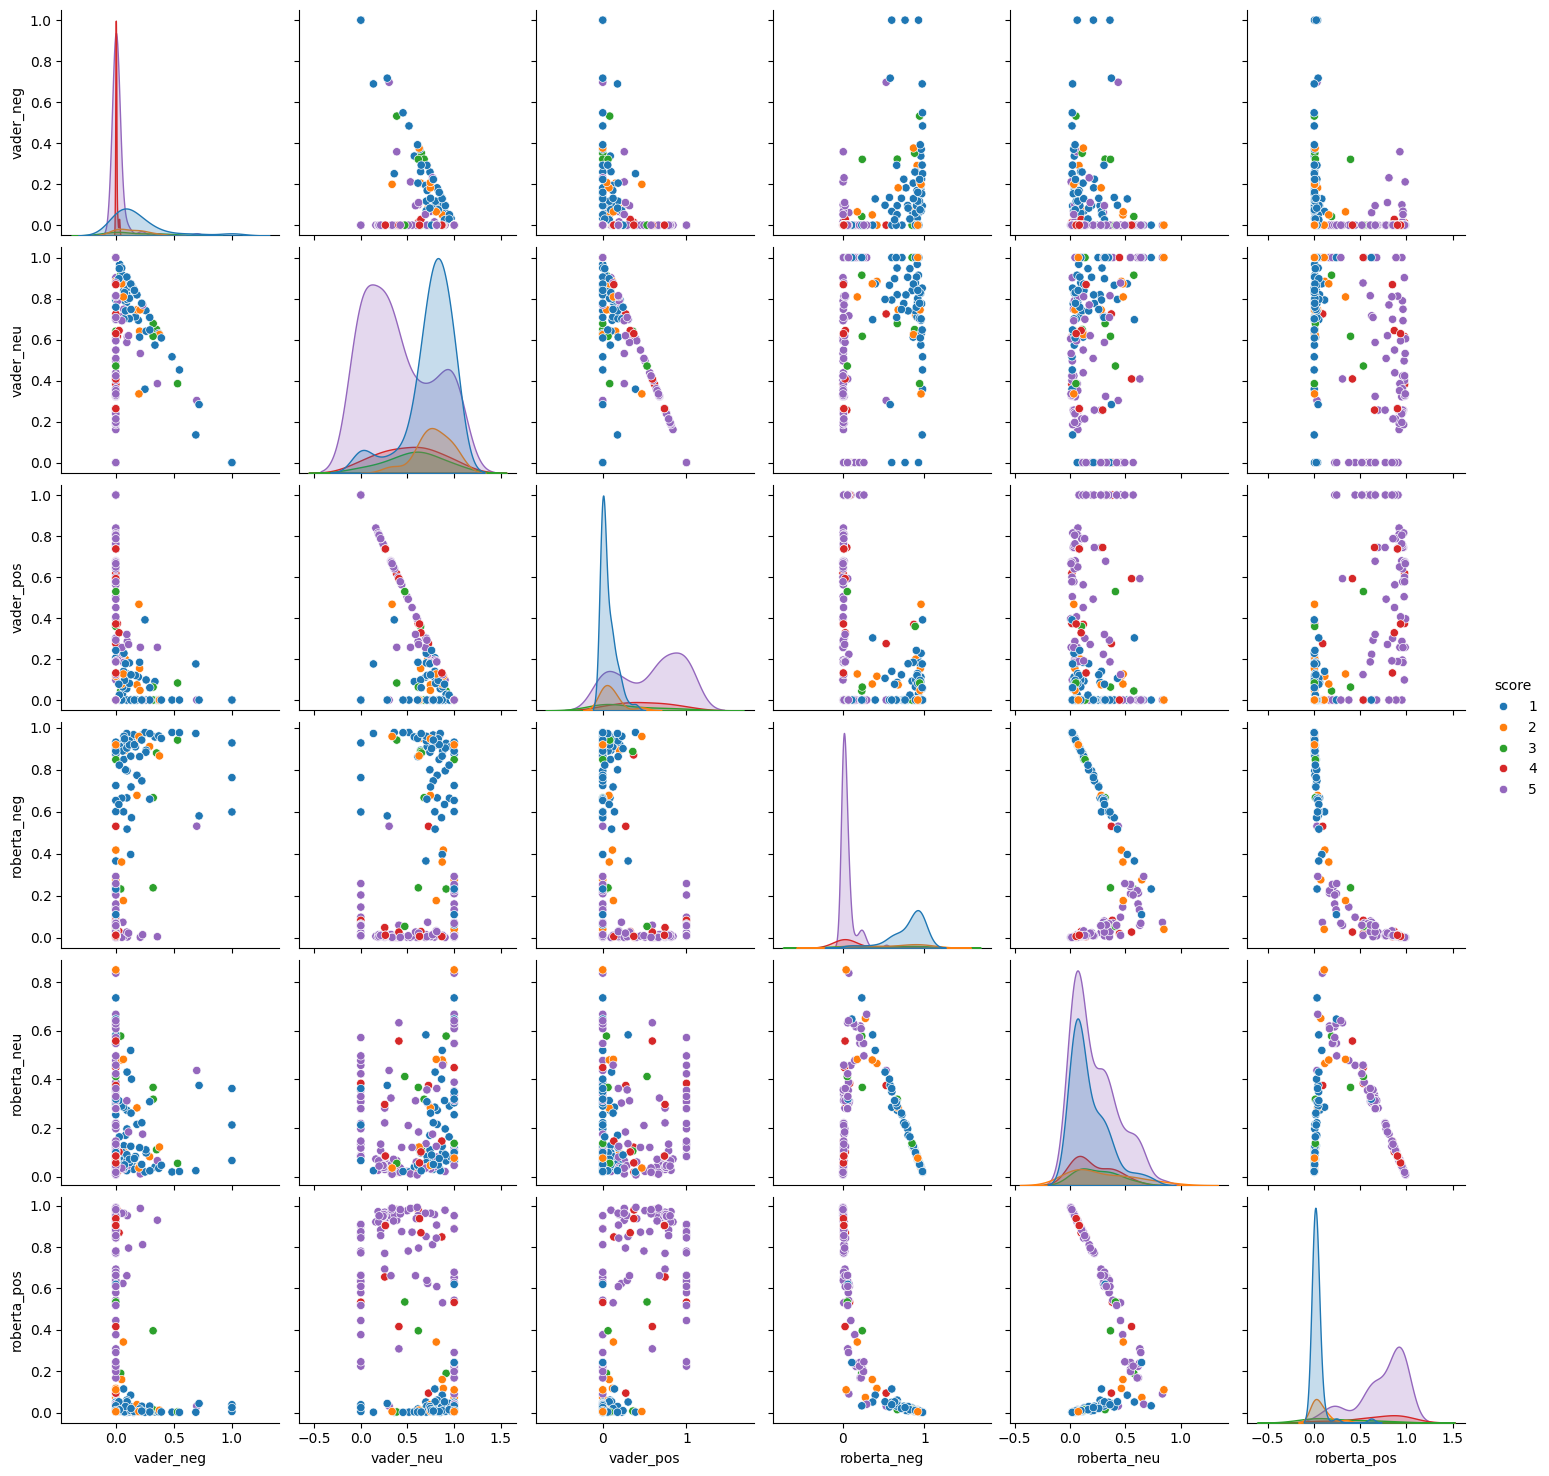

In [96]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='score',
            palette='tab10')
plt.show()

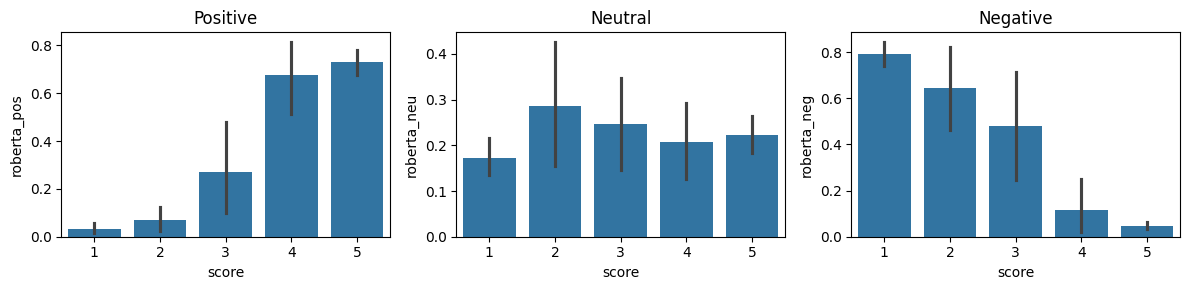

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='score', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='score', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='score', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [98]:
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokinizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [101]:
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokinizer)
print(example)
print(nlp(example))
another_example = "so happy to be here"
print(another_example)
print(nlp(another_example))

Device set to use cpu


It used to be good, not anymore, it's now based on a plan in order to save anything from photos to files, and not cheap or affordable, the minimum offer I got was about $155 per year or $16 a month, sorry but I guess unless you make it affordable, I will probably not subscribe to such a thing, specially when I have a big family and the money goes for more important bills and groceries... disappointed!
[{'label': 'NEGATIVE', 'score': 0.9995089769363403}]
so happy to be here
[{'label': 'POSITIVE', 'score': 0.9998737573623657}]


In [107]:
def distilbert_score(example: str) -> float:
  output = nlp(example)[0]
  score = output['score'] * -1 if output['label'] == 'NEGATIVE' else output['score']
  return score

In [108]:
print(distilbert_score(example))
print(distilbert_score(another_example))

-0.9995089769363403
0.9998737573623657


In [110]:
distilbert_result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['content']
  id = row['Id']
  distilbert_result[id] = {'distilbert_score': distilbert_score(text)}


  0%|          | 0/200 [00:00<?, ?it/s]

In [114]:
distilbert = pd.DataFrame(distilbert_result).T
distilbert = distilbert.reset_index().rename(columns={'index': 'Id'})
all_in_one = distilbert.merge(results_df, how='left')

In [115]:
all_in_one.head()

,Id,distilbert_score,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,content,score
0,0,-0.999509,0.069,0.839,0.092,0.1733,0.849034,0.127174,0.023792,"It used to be good, not anymore, it's now base...",1
1,1,0.999872,0.000,0.000,1.000,0.8316,0.010842,0.089227,0.899931,Excellent awesome,5
2,2,0.997678,0.000,0.902,0.098,0.3612,0.001349,0.021216,0.977435,My cloud storage companion since first use. Re...,5
3,3,0.999843,0.000,0.000,1.000,0.5719,0.008278,0.083049,0.908672,excellent,5
4,4,0.999827,0.000,0.000,1.000,0.4404,0.008477,0.129124,0.862399,Good 👍 👍,5


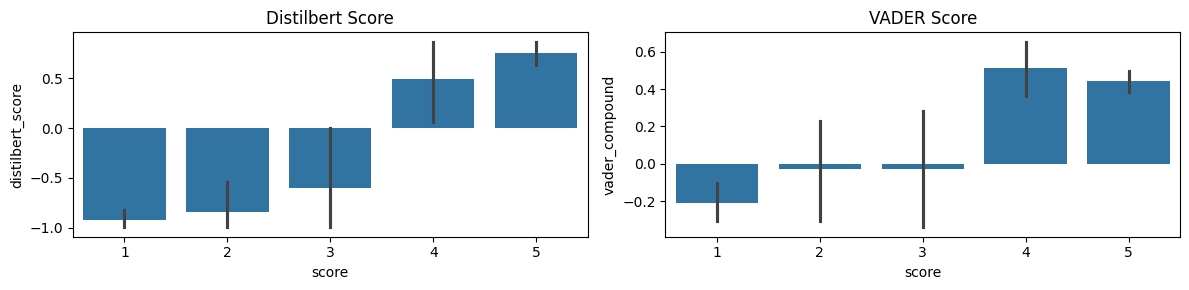

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=all_in_one, x='score', y='distilbert_score', ax=axs[0])
sns.barplot(data=all_in_one, x='score', y='vader_compound', ax=axs[1])
axs[0].set_title('Distilbert Score')
axs[1].set_title('VADER Score')
plt.tight_layout()
plt.show()